# Treinamento do Modelo

### Importando as bibliotecas

In [5]:
import pandas as pd
from pathlib import Path
from scipy.sparse import load_npz
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

### Carregando os Dados Processados

In [6]:
data_path = Path("../data/processed")

# Carregar matrizes de features
X_train = load_npz(data_path / "X_train.npz")
X_val = load_npz(data_path / "X_val.npz")
X_test = load_npz(data_path / "X_test.npz")

# Carregar labels
y_train = pd.read_csv(data_path / "y_train.csv")["label"].values
y_val = pd.read_csv(data_path / "y_val.csv")["label"].values
y_test = pd.read_csv(data_path / "y_test.csv")["label"].values

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (16447, 248497)
X_val shape: (4112, 248497)
X_test shape: (2285, 248497)
y_train shape: (16447,)


### Definindo modelos a serem treinados

**Sobre o param_grid**
Este bloco define, para cada modelo, quais hiperparametros serao testados no GridSearch. A ideia e comparar variacoes simples e comuns (regularizacao, pesos de classe e funcao de perda) para achar a melhor combinacao sem exagerar no custo computacional. As faixas escolhidas cobrem valores baixos, medios e altos, ajudando a equilibrar desempenho e risco de overfitting.

In [ ]:
param_grid = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=2000, solver="liblinear"),
        'params': {
            'C': [0.01, 0.1, 1.0, 3.0, 10],
            'max_iter': [1000, 2000],
            'class_weight': [None, "balanced"],
        }
    },
    'Linear SVC': {
        'model': LinearSVC(random_state=42),
        'params': {
            'C': [0.01, 0.1, 1.0, 3.0, 10],
            'loss': ["hinge", "squared_hinge"],
            'class_weight': [None, "balanced"],
        }
    },
    'SGD Classifier': {
        'model': SGDClassifier(random_state=42),
        'params': {
            'loss': ["hinge", "log_loss", "modified_huber"],
            'alpha': [1e-5, 1e-4, 1e-3],
            'penalty': ['l2', 'l1', 'elasticnet'],
            'l1_ratio': [0.15, 0.5, 0.85],
            'class_weight': [None, "balanced"],
        }
    },
    'Multinomial NB': {
        'model': MultinomialNB(random_state=42),
        'params': {
            'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
            'fit_prior': [True, False],
        }
    }
}

print(f"Modelos configurados: {list(param_grid.keys())}\n")

Modelos configurados: ['Logistic Regression', 'Linear SVC', 'SGD Classifier', 'Multinomial NB']



O grid search foi executado para todos os modelos do param grid, variando todos os parâmetros, e para evitar overfitting foi configurado com um cross validation de 5 folds, utilizando como métrica principal para decidir o melhor modelo o f1-score, pois é a métrica mais equilibrada, que avalia tanto os falsos positivos, quanto os falsos negativos

In [8]:
# Executando o Grid Search para cada modelo
results = {}

for model_name, config in param_grid.items():
    print(f'Treinando {model_name}...')
    
    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=0
    )
    
    grid.fit(X_train, y_train)
    results[model_name] = grid
    
    # Predições no validation set
    y_pred = grid.best_estimator_.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    
    print(f'  Best F1 Score (CV): {grid.best_score_:.4f}')
    print(f'  F1 Score (Validation): {f1:.4f}')
    print(f'  Melhores parâmetros: {grid.best_params_}')
    print()

# Resumo dos melhores modelos
print("\n" + "="*60)
print("RESUMO DOS MELHORES RESULTADOS")
print("="*60 + "\n")

for model_name, grid in results.items():
    y_pred = grid.best_estimator_.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    print(f"{model_name}:")
    print(f"  F1 Score (Validation): {f1:.4f}")
    print(f"  Melhores parâmetros: {grid.best_params_}")
    print(f"  Relatório de classificação:")
    print(classification_report(y_val, y_pred))
    print()


Treinando Logistic Regression...
  Best F1 Score (CV): 0.9911
  F1 Score (Validation): 0.9952
  Melhores parâmetros: {'C': 10, 'class_weight': 'balanced', 'max_iter': 1000}

Treinando Linear SVC...
  Best F1 Score (CV): 0.9933
  F1 Score (Validation): 0.9952
  Melhores parâmetros: {'C': 3.0, 'class_weight': None, 'loss': 'hinge'}

Treinando SGD Classifier...
  Best F1 Score (CV): 0.9972
  F1 Score (Validation): 0.9976
  Melhores parâmetros: {'alpha': 1e-05, 'class_weight': None, 'l1_ratio': 0.85, 'loss': 'hinge', 'penalty': 'elasticnet'}

Treinando Multinomial NB...
  Best F1 Score (CV): 0.9546
  F1 Score (Validation): 0.9562
  Melhores parâmetros: {'alpha': 0.01, 'fit_prior': True}


RESUMO DOS MELHORES RESULTADOS

Logistic Regression:
  F1 Score (Validation): 0.9952
  Melhores parâmetros: {'C': 10, 'class_weight': 'balanced', 'max_iter': 1000}
  Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3064
   

### Teste do Modelo

Após ajustar os hiperparâmetros no conjunto de validação, o modelo foi avaliado no conjunto de teste, para garantir que ele teria uma boa generalização, obtendo um ótimo desempenho com f1-score de 99.82%

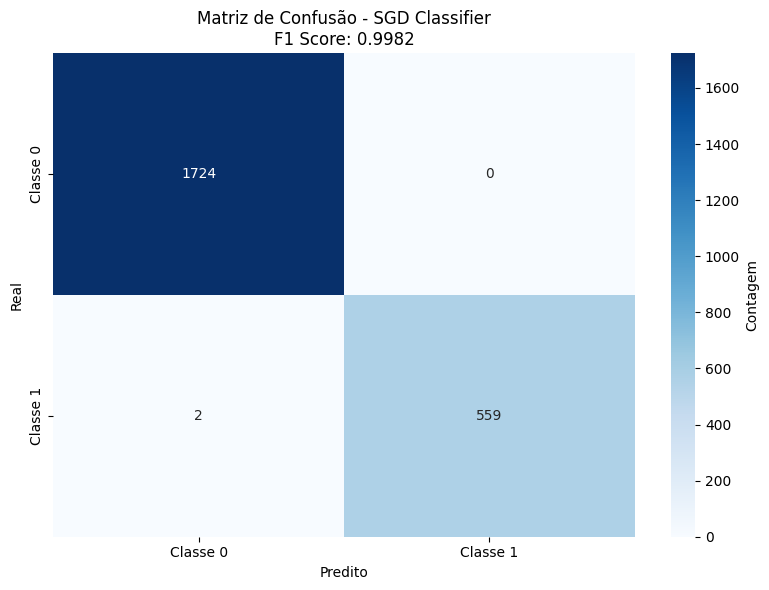

In [9]:
best_overall_model_name = None
best_overall_grid = None
best_overall_f1 = -1

for model_name, grid in results.items():
    y_pred = grid.best_estimator_.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_overall_f1:
        best_overall_f1 = f1
        best_overall_grid = grid
        best_overall_model_name = model_name

# Gerar matriz de confusão
y_pred_best = best_overall_grid.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'],
            cbar_kws={'label': 'Contagem'})
plt.title(f'Matriz de Confusão - {best_overall_model_name}\nF1 Score: {best_overall_f1:.4f}')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.tight_layout()
plt.show()

### Salvando o modelo

In [10]:
joblib.dump(best_overall_grid.best_estimator_, '../models/best_model.joblib')

['../models/best_model.joblib']